### Imports iniciais

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans,AgglomerativeClustering


### Pré-Processamento


In [2]:
df = pd.read_csv("akc-data-latest.csv")

In [3]:
df.head()

,Unnamed: 0,description,temperament,popularity,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,...,grooming_frequency_value,grooming_frequency_category,shedding_value,shedding_category,energy_level_value,energy_level_category,trainability_value,trainability_category,demeanor_value,demeanor_category
0,Affenpinscher,The Affen’s apish look has been described many...,"Confident, Famously Funny, Fearless",148,22.86,29.21,3.175147,4.535924,12.0,15.0,...,0.6,2-3 Times a Week Brushing,0.6,Seasonal,0.6,Regular Exercise,0.8,Easy Training,1.0,Outgoing
1,Afghan Hound,"The Afghan Hound is an ancient breed, his whol...","Dignified, Profoundly Loyal, Aristocratic",113,63.50,68.58,22.679619,27.215542,12.0,15.0,...,0.8,Daily Brushing,0.2,Infrequent,0.8,Energetic,0.2,May be Stubborn,0.2,Aloof/Wary
2,Airedale Terrier,The Airedale Terrier is the largest of all ter...,"Friendly, Clever, Courageous",60,58.42,58.42,22.679619,31.751466,11.0,14.0,...,0.6,2-3 Times a Week Brushing,0.4,Occasional,0.6,Regular Exercise,1.0,Eager to Please,0.8,Friendly
3,Akita,"Akitas are burly, heavy-boned spitz-type dogs ...","Courageous, Dignified, Profoundly Loyal",47,60.96,71.12,31.751466,58.967008,10.0,13.0,...,0.8,Daily Brushing,0.6,Seasonal,0.8,Energetic,1.0,Eager to Please,0.6,Alert/Responsive
4,Alaskan Malamute,The Alaskan Malamute stands 23 to 25 inches at...,"Affectionate, Loyal, Playful",58,58.42,63.50,34.019428,38.555351,10.0,14.0,...,0.6,2-3 Times a Week Brushing,0.6,Seasonal,0.8,Energetic,0.4,Independent,0.8,Friendly


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   277 non-null    object 
 1   description                  277 non-null    object 
 2   temperament                  276 non-null    object 
 3   popularity                   198 non-null    object 
 4   min_height                   277 non-null    float64
 5   max_height                   277 non-null    float64
 6   min_weight                   275 non-null    float64
 7   max_weight                   275 non-null    float64
 8   min_expectancy               274 non-null    float64
 9   max_expectancy               274 non-null    float64
 10  group                        277 non-null    object 
 11  grooming_frequency_value     270 non-null    float64
 12  grooming_frequency_category  270 non-null    object 
 13  shedding_value      

In [5]:
#dropando colunas de tipo object, exceto a coluna popularidade e a group, que eu vou usar na classificação
object_cols = df.select_dtypes(include=['object']).columns
object_cols = object_cols.drop(["popularity","group"])

df = df.drop(columns=object_cols)

In [6]:
df.isna().sum()

popularity                  79
min_height                   0
max_height                   0
min_weight                   2
max_weight                   2
min_expectancy               3
max_expectancy               3
group                        0
grooming_frequency_value     7
shedding_value              20
energy_level_value           6
trainability_value          24
demeanor_value              25
dtype: int64

### Agregação de colunas

In [7]:
df['average_height'] = df[['min_height', 'max_height']].mean(axis=1)
df['average_weight'] = df[['min_weight', 'max_weight']].mean(axis=1)
df['average_expectancy'] = df[['min_expectancy', 'max_expectancy']].mean(axis=1)


df.drop(columns=['min_height', 'max_height', 'min_weight', 'max_weight', 
                 'min_expectancy', 'max_expectancy'], inplace=True)


In [8]:
df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce')

df = df.apply(lambda x: x.fillna(x.mean()) if x.name != 'group' else x, axis=0)

### Normalizando os dados

In [9]:
df.set_index('group', inplace=True)

In [10]:

scaler = MinMaxScaler()

df_esc = scaler.fit_transform(df)
df_esc = pd.DataFrame(df_esc, columns=df.columns, index=df.index)
df = df_esc

### Correlação

In [11]:
df.reset_index(inplace=True)

<Axes: >

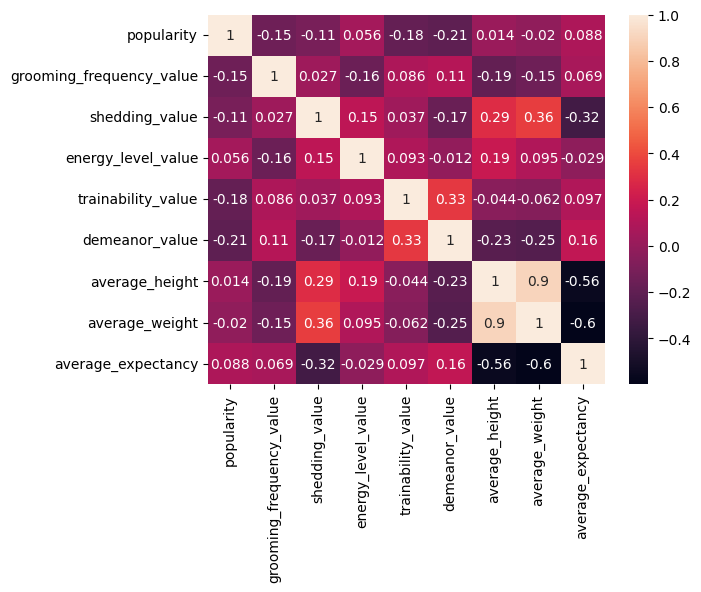

In [12]:
correlacao = df.drop("group", axis=1).corr(method='spearman')
sns.heatmap(correlacao, annot=True)

In [13]:
#como a coluna de avarage_height e average_weight são muito correlacionadas, vou dropar uma delas
df.drop(columns=['average_weight'], inplace=True)

# Supervisionado

### Divisão entre treino e teste

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("group", axis=1), df["group"], test_size=0.25, random_state=42)


In [15]:
df.isna().sum()

group                       0
popularity                  0
grooming_frequency_value    0
shedding_value              0
energy_level_value          0
trainability_value          0
demeanor_value              0
average_height              0
average_expectancy          0
dtype: int64

In [16]:
#Fazendo um resampling para balancear as classes

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
y_resampled.value_counts() 

Sporting Group              51
Terrier Group               51
Working Group               51
Foundation Stock Service    51
Herding Group               51
Miscellaneous Class         51
Hound Group                 51
Non-Sporting Group          51
Toy Group                   51
Name: group, dtype: int64

## Naive Bayes

In [17]:
model = GaussianNB()

model.fit(X_resampled, y_resampled)
predicted = model.predict(X_test)

### Avaliação de resultados

In [18]:
value = df['group'].unique()

<Figure size 1000x700 with 0 Axes>

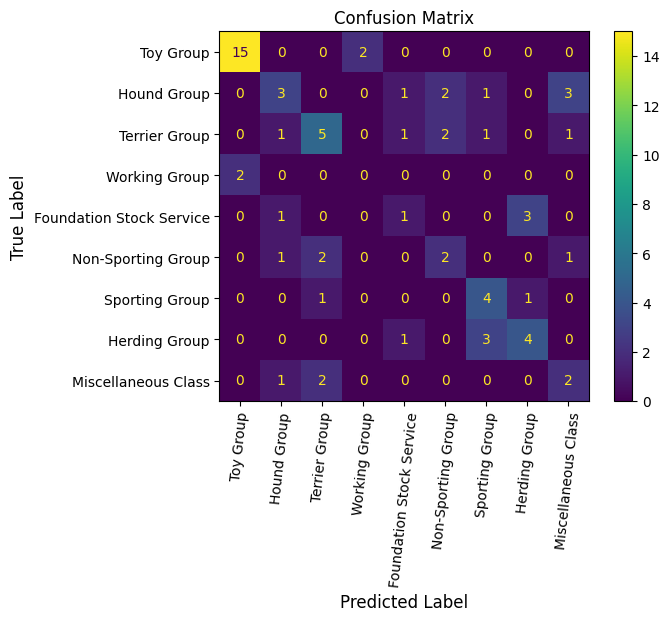

In [19]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))

cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=value)

cmd.plot()

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=84)  
plt.show()

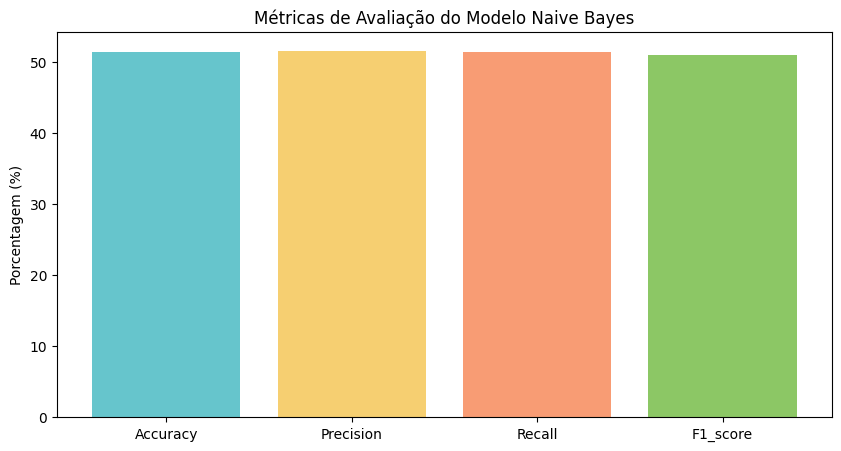

Accuracy: 51.43%
Precision: 51.62%
Recall: 51.43%
F1 Score: 51.06%


In [20]:
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred, average='weighted') * 100
recall = recall_score(y_test, y_pred, average='weighted') * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

metrics = ['Accuracy', 'Precision', 'Recall', 'F1_score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(10, 5))
plt.bar(metrics, values, color=['#66c5cc', '#f6cf71', '#f89c74', '#8cc765', '#9eb9f3'])
plt.ylabel('Porcentagem (%)')
plt.title('Métricas de Avaliação do Modelo Naive Bayes')


plt.show()

print(f'Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.2f}%')
print(f'Recall: {recall:.2f}%')
print(f'F1 Score: {f1:.2f}%')

## Random Forest

In [21]:
rf = RandomForestClassifier()
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

rand_search.fit(X_resampled, y_resampled)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002707E7A56F0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002707E727E20>})

In [22]:

best_rf = rand_search.best_estimator_

print('Melhores Hiperparâmetros:',  rand_search.best_params_)

max_depth = rand_search.best_params_['max_depth']
n_estimators = rand_search.best_params_['n_estimators']

Melhores Hiperparâmetros: {'max_depth': 12, 'n_estimators': 101}


In [23]:
rf = RandomForestClassifier(max_depth= max_depth, n_estimators= n_estimators)
rf.fit(X_resampled, y_resampled)

RandomForestClassifier(max_depth=12, n_estimators=101)

### Avaliação de resultados

In [24]:
y_pred = best_rf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred) * 100)

Accuracy: 47.14285714285714


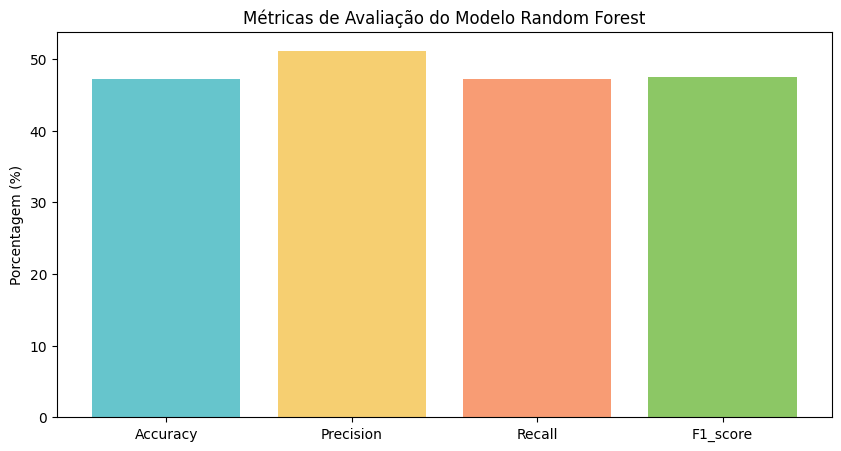

Accuracy: 47.14%
Precision: 51.15%
Recall: 47.14%
F1 Score: 47.53%


In [25]:
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred, average='weighted') * 100
recall = recall_score(y_test, y_pred, average='weighted') * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

metrics = ['Accuracy', 'Precision', 'Recall', 'F1_score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(10, 5))
plt.bar(metrics, values, color=['#66c5cc', '#f6cf71', '#f89c74', '#8cc765', '#9eb9f3'])
plt.ylabel('Porcentagem (%)')
plt.title('Métricas de Avaliação do Modelo Random Forest')


plt.show()

print(f'Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.2f}%')
print(f'Recall: {recall:.2f}%')
print(f'F1 Score: {f1:.2f}%')

<Figure size 1000x700 with 0 Axes>

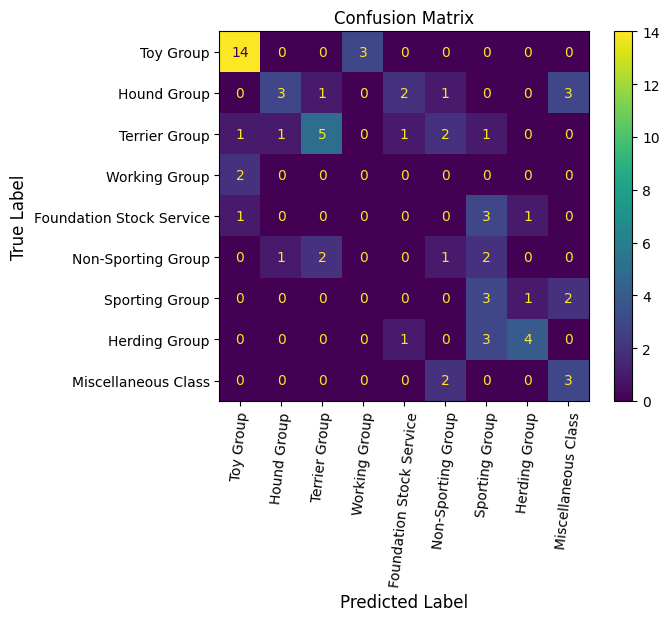

In [26]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))

cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=value)

cmd.plot()

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=84)  
plt.show()

C:\Users\felip\AppData\Local\Temp\ipykernel_24844\187797369.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_scores, y=feature_scores.index, palette='viridis')


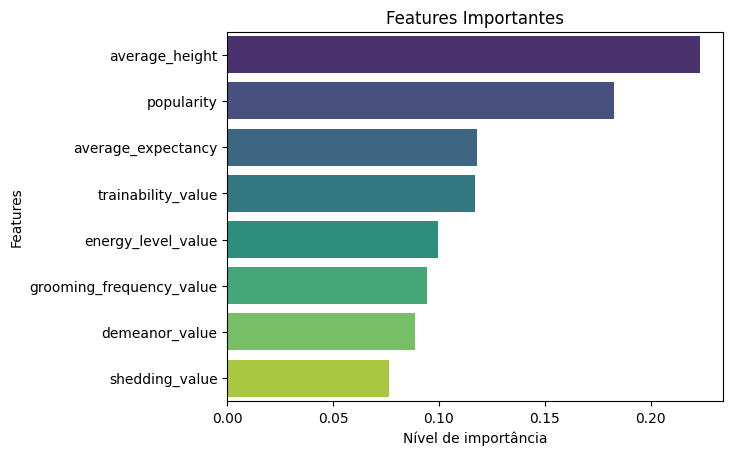

In [27]:
#Uma das principais vantagens de uso de Random Forest é a possibilidade de verificar a importância das features

feature_scores = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

sns.barplot(x=feature_scores, y=feature_scores.index, palette='viridis')

plt.xlabel('Nível de importância')
plt.ylabel('Features')
plt.title("Features Importantes")

plt.show()

## MLP

In [28]:
clf = MLPClassifier(random_state=42, max_iter=1000).fit(X_resampled, y_resampled)

C:\Users\felip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [29]:
y_pred = clf.predict(X_test)


<Figure size 1000x700 with 0 Axes>

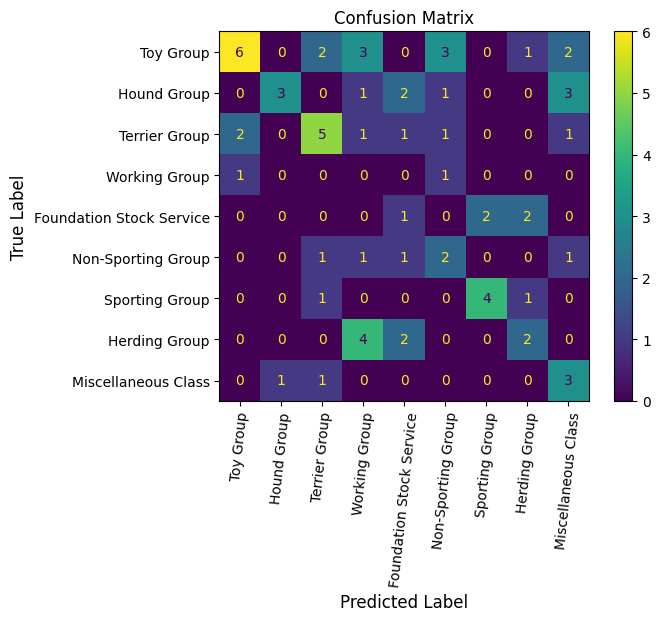

In [30]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))

cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=value)

cmd.plot()

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=84)  
plt.show()

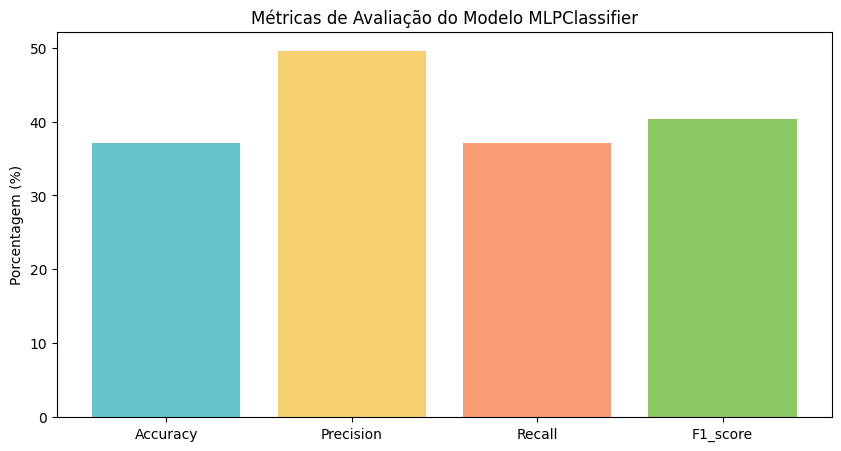

Accuracy: 37.14%
Precision: 49.59%
Recall: 37.14%
F1 Score: 40.29%


In [31]:

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred, average='weighted') * 100
recall = recall_score(y_test, y_pred, average='weighted') * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

metrics = ['Accuracy', 'Precision', 'Recall', 'F1_score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(10, 5))
plt.bar(metrics, values, color=['#66c5cc', '#f6cf71', '#f89c74', '#8cc765', '#9eb9f3'])
plt.ylabel('Porcentagem (%)')
plt.title('Métricas de Avaliação do Modelo MLPClassifier')


plt.show()

print(f'Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.2f}%')
print(f'Recall: {recall:.2f}%')
print(f'F1 Score: {f1:.2f}%')

# Não Supervisionado

## K-means

In [32]:
df_X = df.drop(columns=["group"])

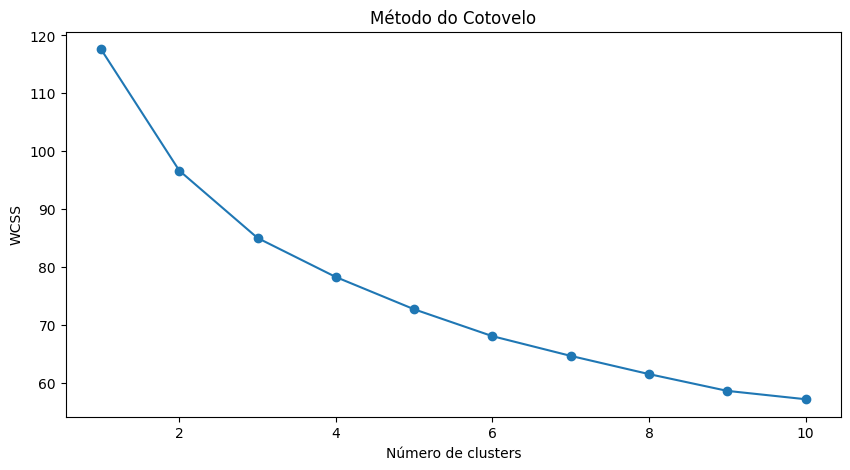

In [33]:

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.show()

In [34]:
kmeans = KMeans(n_clusters = 3, random_state = 0, n_init='auto')
kmeans.fit(df_X)

KMeans(n_clusters=3, random_state=0)

### Métrica de avaliação do modelo (silhueta)

In [35]:
silhouette_score(df_X, kmeans.fit_predict(df_X))

0.1554330415425228

## Hierarquia

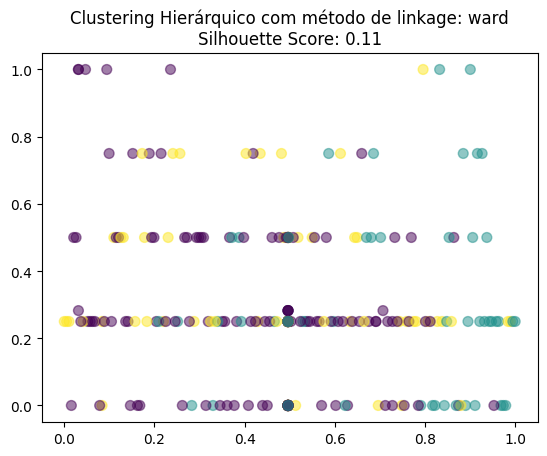

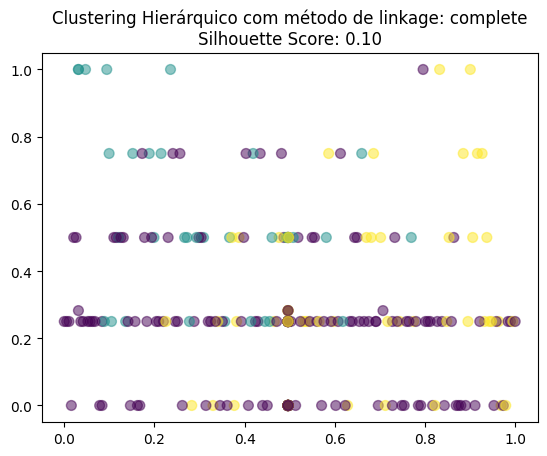

The Silhouette Score for ward linkage: 0.11046839610150705
The Silhouette Score for complete linkage: 0.09660381575685209


In [36]:
k = 3
linkage_methods = ['ward', 'complete']

silhouette_scores = {}

for linkage_method in linkage_methods:
    clustering = AgglomerativeClustering(n_clusters=k, linkage=linkage_method)
    clustering.fit(df_X)
    
    score = silhouette_score(df_X, clustering.labels_)
    silhouette_scores[linkage_method] = score
    
    plt.figure()
    plt.scatter(df_X.iloc[:, 0], df_X.iloc[:, 1], c=clustering.labels_, cmap='viridis', s=50, alpha=0.5)
    plt.title(f'Clustering Hierárquico com método de linkage: {linkage_method}\nSilhouette Score: {score:.2f}')
    plt.show()

for method, score in silhouette_scores.items():
    print(f"The Silhouette Score for {method} linkage: {score}")
